In [ ]:
!pip install spectral

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization, MaxPooling3D
from keras.layers import Dropout, Input
from keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from matplotlib.widgets import RectangleSelector
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D
from operator import truediv
from keras.utils import plot_model
from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

In [ ]:
## GLOBAL VARIABLES
dataset = 'IP'
test_ratio = 0.3
windowSize = 25

<h1>Data Acquistion

In [ ]:
def loadData():
    data_path = '/content/drive/MyDrive/softComputingProj'
    if dataset == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
        class_name = [ "Alfalfa", "Corn-notill", "Corn-mintill","Corn", "Grass-pasture",
                       "Grass-trees","Grass-pasture-mowed", "Hay-windrowed", "Oats","Soybean-notill", "Soybean-mintill", "Soybean-clean","Wheat", "Woods", "Buildings-Grass-Trees-Drives","Stone-Steel-Towers"]
    elif dataset == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
        class_name = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow',
                        'Fallow_rough_plow','Fallow_smooth','Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green','Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk','Vinyard_untrained','Vinyard_vertical']
    elif dataset == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
        class_name = ['Asphalt', 'Meadows', 'Gravel', 'Trees','Painted metal sheets', 'Bare Soil',
                      'Bitumen','Self-Blocking Bricks', 'Shadows']
    return data, labels, class_name

In [ ]:
X, y, class_name = loadData()
X.shape, y.shape

((145, 145, 200), (145, 145))

<h1>Visualize the Image

/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning:

Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.



ImageView object:
  Display bands       :  [0, 100.0, 199]
  Interpolation       :  <default>
  RGB data limits     :
    R: [2560.0, 4536.0]
    G: [1169.0, 2511.0]
    B: [981.0, 1036.0]

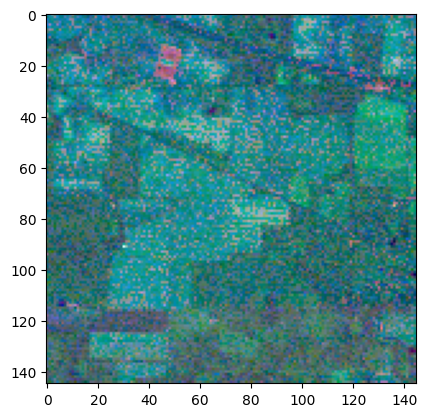

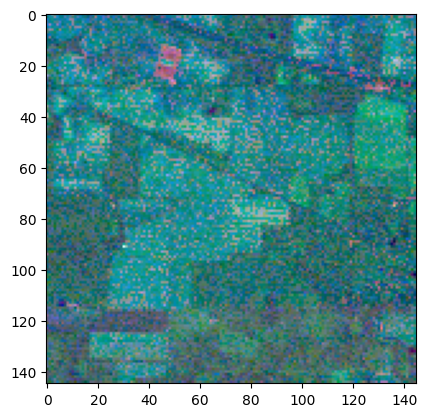

In [ ]:
hyperspectral_data = np.squeeze(X)
spectral.imshow(hyperspectral_data)
spectral.imshow(hyperspectral_data)

<h1>Data Preprocessing

<h3>Remove noise

ImageView object:
  Display bands       :  [0, 100.0, 199]
  Interpolation       :  <default>
  RGB data limits     :
    R: [3113.0, 4283.0]
    G: [1476.0, 2149.0]
    B: [999.0, 1029.0]

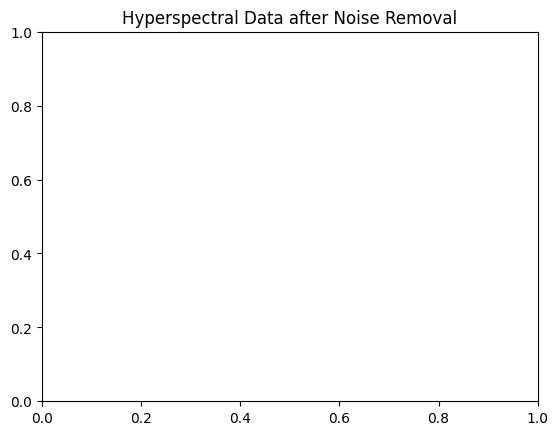

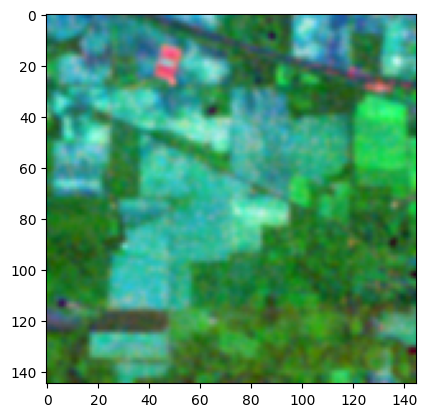

In [ ]:
X = gaussian_filter(X, sigma=1)  # Adjust sigma as needed

# Display the data after noise removal
plt.figure()
plt.title('Hyperspectral Data after Noise Removal')
spectral.imshow(X)

<h2>Smoothening Data

ImageView object:
  Display bands       :  [0, 100.0, 199]
  Interpolation       :  <default>
  RGB data limits     :
    R: [3122.3006993007, 4270.125874125876]
    G: [1478.885780885784, 2119.1398601398646]
    B: [998.6013986013987, 1026.2167832167834]

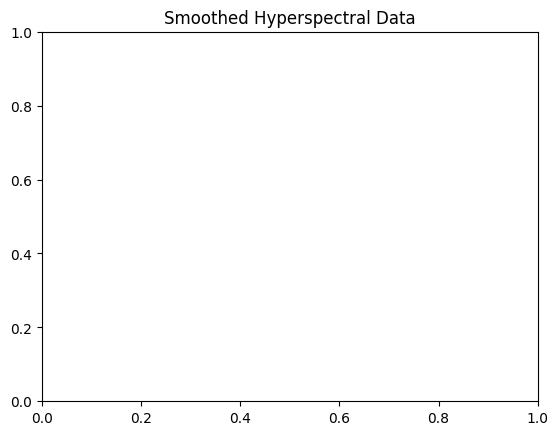

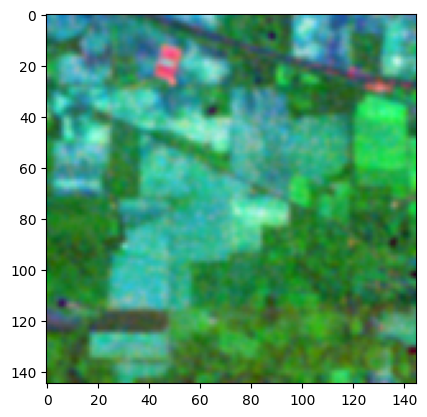

In [ ]:
X = savgol_filter(X, window_length=11, polyorder=3)  # Adjust parameters as needed

# Display the smoothed data
plt.figure()
plt.title('Smoothed Hyperspectral Data')
spectral.imshow(X)

<h1>Band Selection using PCA

In [ ]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [ ]:
K = 30
X,pca = applyPCA(X,numComponents=K)
X.shape

(145, 145, 30)

<h1>Creating Image Cube

In [ ]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
X, y = createImageCubes(X, y, windowSize=windowSize)
X.shape, y.shape

((10249, 25, 25, 30), (10249,))

<h1> Splitting of Data

In [ ]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((7174, 25, 25, 30), (3075, 25, 25, 30), (7174,), (3075,))

In [ ]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(7174, 25, 25, 30, 1)

In [ ]:
ytrain = to_categorical(ytrain)
ytrain.shape

(7174, 16)

<h1>Model Building

In [ ]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

<h2> 3D CNN Model


In [ ]:
input_shape = (S, S, L, 1)

# Updated number of classes for the output
output_units = 16  # Updated number of output units

# Create a Sequential model
model_3D_CNN = Sequential()

# Input layer
model_3D_CNN.add(Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))

# Convolutional layers
model_3D_CNN.add(Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu'))
model_3D_CNN.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3D_CNN.add(Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu'))
model_3D_CNN.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten the output
model_3D_CNN.add(Flatten())

# Fully connected layers
model_3D_CNN.add(Dense(units=256, activation='relu'))
model_3D_CNN.add(Dropout(0.4))

model_3D_CNN.add(Dense(units=128, activation='relu'))
model_3D_CNN.add(Dropout(0.4))

# Output layer
model_3D_CNN.add(Dense(units=output_units, activation='softmax'))

In [ ]:
# Print the model summary
model_3D_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 23, 23, 28, 8)     224       
                                                                 
 conv3d_1 (Conv3D)           (None, 21, 21, 26, 16)    3472      
                                                                 
 max_pooling3d (MaxPooling3  (None, 10, 10, 13, 16)    0         
 D)                                                              
                                                                 
 conv3d_2 (Conv3D)           (None, 8, 8, 11, 32)      13856     
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 4, 4, 5, 32)       0         
 g3D)                                                            
                                                                 
 flatten (Flatten)           (None, 2560)              0

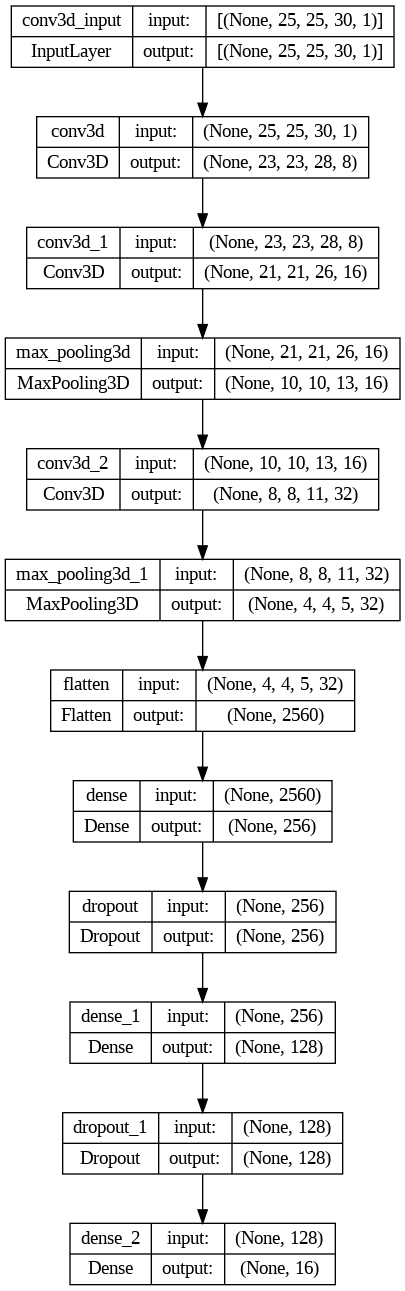

In [ ]:
plot_model(model_3D_CNN, to_file='model.png', show_shapes=True)

In [ ]:
# compiling the model
adam = Adam(learning_rate=0.001, decay=1e-06)
model_3D_CNN.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
# checkpoint
filepath = "model_3D_CNN.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

<h1>Model Training

<h3>Train 3D CNN Model

In [ ]:
history = model_3D_CNN.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)

Epoch 1/100
29/29 [==============================] - ETA: 0s - loss: 1.7936 - accuracy: 0.4367

29/29 [==============================] - 15s 113ms/step - loss: 1.7936 - accuracy: 0.4367
Epoch 2/100
28/29 [===========================>..] - ETA: 0s - loss: 0.4370 - accuracy: 0.8697

29/29 [==============================] - 3s 107ms/step - loss: 0.4367 - accuracy: 0.8698
Epoch 3/100
28/29 [===========================>..] - ETA: 0s - loss: 0.1691 - accuracy: 0.9519

29/29 [==============================] - 3s 107ms/step - loss: 0.1690 - accuracy: 0.9519
Epoch 4/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0841 - accuracy: 0.9725

29/29 [==============================] - 3s 109ms/step - loss: 0.0840 - accuracy: 0.9725
Epoch 5/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0475 - accuracy: 0.9841

29/29 [==============================] - 3s 112ms/step - loss: 0.0476 - accuracy: 0.9841
Epoch 6/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0589 - accuracy: 0.9826

29/29 [==============================] - 3s 117ms/step - loss: 0.0589 - accuracy: 0.9826
Epoch 7/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0328 - accuracy: 0.9895

29/29 [==============================] - 4s 122ms/step - loss: 0.0327 - accuracy: 0.9895
Epoch 8/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0207 - accuracy: 0.9932

29/29 [==============================] - 3s 118ms/step - loss: 0.0207 - accuracy: 0.9932
Epoch 9/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0255 - accuracy: 0.9925

29/29 [==============================] - 4s 122ms/step - loss: 0.0255 - accuracy: 0.9925
Epoch 10/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0249 - accuracy: 0.9916

29/29 [==============================] - 4s 124ms/step - loss: 0.0248 - accuracy: 0.9916
Epoch 11/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0218 - accuracy: 0.9934

29/29 [==============================] - 4s 128ms/step - loss: 0.0218 - accuracy: 0.9934
Epoch 12/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0147 - accuracy: 0.9957

29/29 [==============================] - 3s 118ms/step - loss: 0.0147 - accuracy: 0.9957
Epoch 13/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0180 - accuracy: 0.9955

29/29 [==============================] - 3s 119ms/step - loss: 0.0180 - accuracy: 0.9955
Epoch 14/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0155 - accuracy: 0.9957

29/29 [==============================] - 4s 122ms/step - loss: 0.0155 - accuracy: 0.9957
Epoch 15/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0131 - accuracy: 0.9967

29/29 [==============================] - 4s 126ms/step - loss: 0.0131 - accuracy: 0.9967
Epoch 16/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0151 - accuracy: 0.9951

29/29 [==============================] - 4s 121ms/step - loss: 0.0151 - accuracy: 0.9951
Epoch 17/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0107 - accuracy: 0.9964

29/29 [==============================] - 3s 113ms/step - loss: 0.0107 - accuracy: 0.9964
Epoch 18/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0091 - accuracy: 0.9968

29/29 [==============================] - 3s 111ms/step - loss: 0.0091 - accuracy: 0.9968
Epoch 19/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0064 - accuracy: 0.9983

29/29 [==============================] - 3s 114ms/step - loss: 0.0064 - accuracy: 0.9983
Epoch 20/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0111 - accuracy: 0.9961

29/29 [==============================] - 3s 116ms/step - loss: 0.0111 - accuracy: 0.9961
Epoch 21/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0148 - accuracy: 0.9957

29/29 [==============================] - 3s 113ms/step - loss: 0.0148 - accuracy: 0.9957
Epoch 22/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0152 - accuracy: 0.9965

29/29 [==============================] - 3s 112ms/step - loss: 0.0151 - accuracy: 0.9965
Epoch 23/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0081 - accuracy: 0.9973

29/29 [==============================] - 3s 112ms/step - loss: 0.0081 - accuracy: 0.9974
Epoch 24/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0246 - accuracy: 0.9933

29/29 [==============================] - 3s 114ms/step - loss: 0.0246 - accuracy: 0.9933
Epoch 25/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0095 - accuracy: 0.9972

29/29 [==============================] - 3s 117ms/step - loss: 0.0095 - accuracy: 0.9972
Epoch 26/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0088 - accuracy: 0.9975

29/29 [==============================] - 3s 114ms/step - loss: 0.0088 - accuracy: 0.9975
Epoch 27/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0107 - accuracy: 0.9962

29/29 [==============================] - 3s 114ms/step - loss: 0.0107 - accuracy: 0.9962
Epoch 28/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0099 - accuracy: 0.9972

29/29 [==============================] - 3s 116ms/step - loss: 0.0099 - accuracy: 0.9972
Epoch 29/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0107 - accuracy: 0.9972

29/29 [==============================] - 4s 128ms/step - loss: 0.0107 - accuracy: 0.9972
Epoch 30/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0103 - accuracy: 0.9975

29/29 [==============================] - 4s 121ms/step - loss: 0.0103 - accuracy: 0.9975
Epoch 31/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0050 - accuracy: 0.9986

29/29 [==============================] - 3s 114ms/step - loss: 0.0050 - accuracy: 0.9986
Epoch 32/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0060 - accuracy: 0.9982

29/29 [==============================] - 3s 113ms/step - loss: 0.0061 - accuracy: 0.9982
Epoch 33/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0259 - accuracy: 0.9950

29/29 [==============================] - 3s 114ms/step - loss: 0.0258 - accuracy: 0.9950
Epoch 34/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0141 - accuracy: 0.9968

29/29 [==============================] - 3s 117ms/step - loss: 0.0141 - accuracy: 0.9968
Epoch 35/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0134 - accuracy: 0.9958

29/29 [==============================] - 3s 116ms/step - loss: 0.0134 - accuracy: 0.9958
Epoch 36/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0095 - accuracy: 0.9969

29/29 [==============================] - 3s 112ms/step - loss: 0.0095 - accuracy: 0.9969
Epoch 37/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0068 - accuracy: 0.9975

29/29 [==============================] - 3s 112ms/step - loss: 0.0068 - accuracy: 0.9975
Epoch 38/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0042 - accuracy: 0.9990

29/29 [==============================] - 3s 112ms/step - loss: 0.0042 - accuracy: 0.9990
Epoch 39/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0056 - accuracy: 0.9986

29/29 [==============================] - 3s 115ms/step - loss: 0.0056 - accuracy: 0.9986
Epoch 40/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0061 - accuracy: 0.9987

29/29 [==============================] - 3s 115ms/step - loss: 0.0061 - accuracy: 0.9987
Epoch 41/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0051 - accuracy: 0.9983

29/29 [==============================] - 3s 112ms/step - loss: 0.0051 - accuracy: 0.9983
Epoch 42/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0038 - accuracy: 0.9992

29/29 [==============================] - 3s 112ms/step - loss: 0.0038 - accuracy: 0.9992
Epoch 43/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0023 - accuracy: 0.9993

29/29 [==============================] - 3s 112ms/step - loss: 0.0023 - accuracy: 0.9993
Epoch 44/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0026 - accuracy: 0.9989

29/29 [==============================] - 3s 119ms/step - loss: 0.0026 - accuracy: 0.9989
Epoch 45/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0030 - accuracy: 0.9990

29/29 [==============================] - 3s 118ms/step - loss: 0.0030 - accuracy: 0.9990
Epoch 46/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0094 - accuracy: 0.9985

29/29 [==============================] - 3s 112ms/step - loss: 0.0093 - accuracy: 0.9985
Epoch 47/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0057 - accuracy: 0.9982

29/29 [==============================] - 3s 112ms/step - loss: 0.0057 - accuracy: 0.9982
Epoch 48/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0069 - accuracy: 0.9986

29/29 [==============================] - 3s 113ms/step - loss: 0.0069 - accuracy: 0.9986
Epoch 49/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0055 - accuracy: 0.9983

29/29 [==============================] - 3s 117ms/step - loss: 0.0055 - accuracy: 0.9983
Epoch 50/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0061 - accuracy: 0.9979

29/29 [==============================] - 3s 115ms/step - loss: 0.0061 - accuracy: 0.9979
Epoch 51/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0034 - accuracy: 0.9985

29/29 [==============================] - 3s 112ms/step - loss: 0.0034 - accuracy: 0.9985
Epoch 52/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0034 - accuracy: 0.9993

29/29 [==============================] - 3s 113ms/step - loss: 0.0034 - accuracy: 0.9993
Epoch 53/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0014 - accuracy: 0.9994

29/29 [==============================] - 3s 114ms/step - loss: 0.0014 - accuracy: 0.9994
Epoch 54/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0024 - accuracy: 0.9992

29/29 [==============================] - 3s 116ms/step - loss: 0.0024 - accuracy: 0.9992
Epoch 55/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0023 - accuracy: 0.9989

29/29 [==============================] - 3s 115ms/step - loss: 0.0023 - accuracy: 0.9989
Epoch 56/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0032 - accuracy: 0.9992

29/29 [==============================] - 3s 114ms/step - loss: 0.0032 - accuracy: 0.9992
Epoch 57/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0014 - accuracy: 0.9994

29/29 [==============================] - 3s 113ms/step - loss: 0.0014 - accuracy: 0.9994
Epoch 58/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0079 - accuracy: 0.9986

29/29 [==============================] - 3s 116ms/step - loss: 0.0079 - accuracy: 0.9986
Epoch 59/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0063 - accuracy: 0.9982

29/29 [==============================] - 3s 117ms/step - loss: 0.0063 - accuracy: 0.9982
Epoch 60/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0026 - accuracy: 0.9993

29/29 [==============================] - 3s 114ms/step - loss: 0.0026 - accuracy: 0.9993
Epoch 61/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0052 - accuracy: 0.9990

29/29 [==============================] - 3s 112ms/step - loss: 0.0052 - accuracy: 0.9990
Epoch 62/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0055 - accuracy: 0.9986

29/29 [==============================] - 3s 113ms/step - loss: 0.0055 - accuracy: 0.9986
Epoch 63/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0024 - accuracy: 0.9990

29/29 [==============================] - 3s 115ms/step - loss: 0.0024 - accuracy: 0.9990
Epoch 64/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0048 - accuracy: 0.9986

29/29 [==============================] - 3s 116ms/step - loss: 0.0048 - accuracy: 0.9986
Epoch 65/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0063 - accuracy: 0.9982

29/29 [==============================] - 3s 114ms/step - loss: 0.0063 - accuracy: 0.9982
Epoch 66/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0050 - accuracy: 0.9990

29/29 [==============================] - 3s 112ms/step - loss: 0.0050 - accuracy: 0.9990
Epoch 67/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0033 - accuracy: 0.9990

29/29 [==============================] - 3s 113ms/step - loss: 0.0033 - accuracy: 0.9990
Epoch 68/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0042 - accuracy: 0.9982

29/29 [==============================] - 3s 115ms/step - loss: 0.0042 - accuracy: 0.9982
Epoch 69/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0072 - accuracy: 0.9986

29/29 [==============================] - 3s 117ms/step - loss: 0.0072 - accuracy: 0.9986
Epoch 70/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0075 - accuracy: 0.9983

29/29 [==============================] - 3s 112ms/step - loss: 0.0075 - accuracy: 0.9983
Epoch 71/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0022 - accuracy: 0.9993

29/29 [==============================] - 3s 113ms/step - loss: 0.0022 - accuracy: 0.9993
Epoch 72/100
28/29 [===========================>..] - ETA: 0s - loss: 9.9967e-04 - accuracy: 0.9996

29/29 [==============================] - 3s 112ms/step - loss: 9.9886e-04 - accuracy: 0.9996
Epoch 73/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0020 - accuracy: 0.9996

29/29 [==============================] - 3s 115ms/step - loss: 0.0020 - accuracy: 0.9996
Epoch 74/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0019 - accuracy: 0.9996

29/29 [==============================] - 3s 117ms/step - loss: 0.0019 - accuracy: 0.9996
Epoch 75/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0027 - accuracy: 0.9992

29/29 [==============================] - 3s 113ms/step - loss: 0.0027 - accuracy: 0.9992
Epoch 76/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0016 - accuracy: 0.9994

29/29 [==============================] - 3s 113ms/step - loss: 0.0016 - accuracy: 0.9994
Epoch 77/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0012 - accuracy: 0.9994

29/29 [==============================] - 3s 119ms/step - loss: 0.0012 - accuracy: 0.9994
Epoch 78/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0018 - accuracy: 0.9996

29/29 [==============================] - 3s 115ms/step - loss: 0.0018 - accuracy: 0.9996
Epoch 79/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0018 - accuracy: 0.9996

29/29 [==============================] - 3s 115ms/step - loss: 0.0018 - accuracy: 0.9996
Epoch 80/100
28/29 [===========================>..] - ETA: 0s - loss: 9.9965e-04 - accuracy: 0.9997

29/29 [==============================] - 3s 113ms/step - loss: 9.9882e-04 - accuracy: 0.9997
Epoch 81/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0027 - accuracy: 0.9990

29/29 [==============================] - 3s 113ms/step - loss: 0.0027 - accuracy: 0.9990
Epoch 82/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0030 - accuracy: 0.9987

29/29 [==============================] - 3s 113ms/step - loss: 0.0030 - accuracy: 0.9987
Epoch 83/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0052 - accuracy: 0.9985

29/29 [==============================] - 3s 116ms/step - loss: 0.0052 - accuracy: 0.9985
Epoch 84/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0035 - accuracy: 0.9989

29/29 [==============================] - 3s 116ms/step - loss: 0.0035 - accuracy: 0.9989
Epoch 85/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0016 - accuracy: 0.9994

29/29 [==============================] - 3s 113ms/step - loss: 0.0016 - accuracy: 0.9994
Epoch 86/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9986

29/29 [==============================] - 3s 113ms/step - loss: 0.0046 - accuracy: 0.9986
Epoch 87/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0067 - accuracy: 0.9983

29/29 [==============================] - 3s 113ms/step - loss: 0.0067 - accuracy: 0.9983
Epoch 88/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0075 - accuracy: 0.9982

29/29 [==============================] - 3s 116ms/step - loss: 0.0075 - accuracy: 0.9982
Epoch 89/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0040 - accuracy: 0.9993

29/29 [==============================] - 3s 115ms/step - loss: 0.0040 - accuracy: 0.9993
Epoch 90/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9992

29/29 [==============================] - 3s 113ms/step - loss: 0.0047 - accuracy: 0.9992
Epoch 91/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0091 - accuracy: 0.9969

29/29 [==============================] - 3s 114ms/step - loss: 0.0091 - accuracy: 0.9969
Epoch 92/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0067 - accuracy: 0.9989

29/29 [==============================] - 3s 113ms/step - loss: 0.0067 - accuracy: 0.9989
Epoch 93/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0037 - accuracy: 0.9986

29/29 [==============================] - 3s 117ms/step - loss: 0.0037 - accuracy: 0.9986
Epoch 94/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0029 - accuracy: 0.9993

29/29 [==============================] - 3s 114ms/step - loss: 0.0029 - accuracy: 0.9993
Epoch 95/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0173 - accuracy: 0.9975

29/29 [==============================] - 3s 113ms/step - loss: 0.0173 - accuracy: 0.9975
Epoch 96/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0060 - accuracy: 0.9982

29/29 [==============================] - 3s 113ms/step - loss: 0.0060 - accuracy: 0.9982
Epoch 97/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0017 - accuracy: 0.9996

29/29 [==============================] - 3s 114ms/step - loss: 0.0017 - accuracy: 0.9996
Epoch 98/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0024 - accuracy: 0.9992

29/29 [==============================] - 3s 116ms/step - loss: 0.0024 - accuracy: 0.9992
Epoch 99/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0034 - accuracy: 0.9994

29/29 [==============================] - 3s 114ms/step - loss: 0.0034 - accuracy: 0.9994
Epoch 100/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0028 - accuracy: 0.9993

29/29 [==============================] - 3s 113ms/step - loss: 0.0028 - accuracy: 0.9993


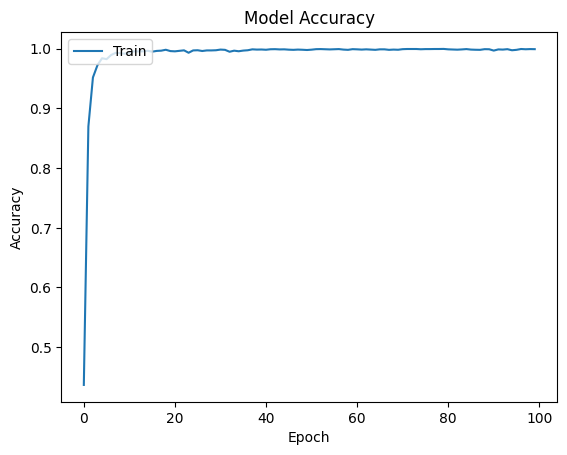

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train'], loc='upper left')
plt.show()

In [ ]:
model_3D_CNN.save("model_3D_CNN.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



<h1>Hybrid CNN model</h1>

In [ ]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
#print(conv_layer3._keras_shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

# define the model with input layer and output layer
Hybrid_model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
Hybrid_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 25, 30, 1)]   0         
                                                                 
 conv3d_3 (Conv3D)           (None, 23, 23, 24, 8)     512       
                                                                 
 conv3d_4 (Conv3D)           (None, 21, 21, 20, 16)    5776      
                                                                 
 conv3d_5 (Conv3D)           (None, 19, 19, 18, 32)    13856     
                                                                 
 reshape (Reshape)           (None, 19, 19, 576)       0         
                                                                 
 conv2d (Conv2D)             (None, 17, 17, 64)        331840    
                                                                 
 flatten_1 (Flatten)         (None, 18496)             0     

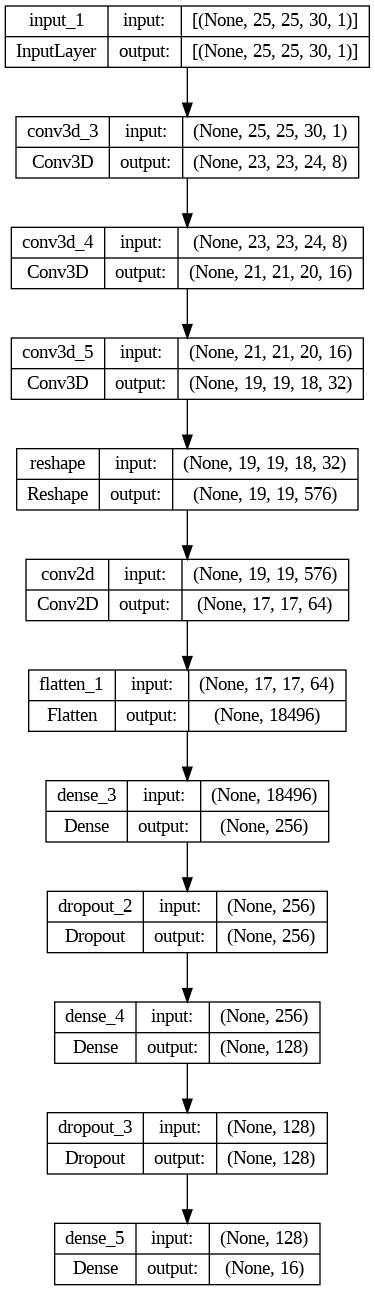

In [ ]:
plot_model(Hybrid_model, to_file='model.png', show_shapes=True)

In [ ]:
# compiling the model
adam = Adam(learning_rate=0.001, decay=1e-06)
Hybrid_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
# checkpoint
filepath = "hybrid_model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = Hybrid_model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)

Epoch 1/100
29/29 [==============================] - ETA: 0s - loss: 2.2483 - accuracy: 0.3043

29/29 [==============================] - 10s 215ms/step - loss: 2.2483 - accuracy: 0.3043
Epoch 2/100
28/29 [===========================>..] - ETA: 0s - loss: 0.8398 - accuracy: 0.7324

29/29 [==============================] - 6s 207ms/step - loss: 0.8394 - accuracy: 0.7325
Epoch 3/100
28/29 [===========================>..] - ETA: 0s - loss: 0.2467 - accuracy: 0.9245

29/29 [==============================] - 6s 212ms/step - loss: 0.2466 - accuracy: 0.9246
Epoch 4/100
28/29 [===========================>..] - ETA: 0s - loss: 0.1426 - accuracy: 0.9579

29/29 [==============================] - 6s 211ms/step - loss: 0.1425 - accuracy: 0.9579
Epoch 5/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0837 - accuracy: 0.9745

29/29 [==============================] - 6s 210ms/step - loss: 0.0848 - accuracy: 0.9744
Epoch 6/100
28/29 [===========================>..] - ETA: 0s - loss: 0.1461 - accuracy: 0.9602

29/29 [==============================] - 6s 211ms/step - loss: 0.1460 - accuracy: 0.9603
Epoch 7/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0504 - accuracy: 0.9865

29/29 [==============================] - 6s 206ms/step - loss: 0.0503 - accuracy: 0.9865
Epoch 8/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0517 - accuracy: 0.9855

29/29 [==============================] - 6s 207ms/step - loss: 0.0517 - accuracy: 0.9855
Epoch 9/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0407 - accuracy: 0.9887

29/29 [==============================] - 6s 207ms/step - loss: 0.0407 - accuracy: 0.9887
Epoch 10/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0192 - accuracy: 0.9944

29/29 [==============================] - 6s 204ms/step - loss: 0.0192 - accuracy: 0.9944
Epoch 11/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0222 - accuracy: 0.9927

29/29 [==============================] - 6s 206ms/step - loss: 0.0222 - accuracy: 0.9928
Epoch 12/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0195 - accuracy: 0.9948

29/29 [==============================] - 6s 205ms/step - loss: 0.0194 - accuracy: 0.9948
Epoch 13/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0155 - accuracy: 0.9947

29/29 [==============================] - 6s 204ms/step - loss: 0.0154 - accuracy: 0.9947
Epoch 14/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0145 - accuracy: 0.9954

29/29 [==============================] - 6s 208ms/step - loss: 0.0145 - accuracy: 0.9954
Epoch 15/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0102 - accuracy: 0.9968

29/29 [==============================] - 6s 206ms/step - loss: 0.0103 - accuracy: 0.9968
Epoch 16/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0215 - accuracy: 0.9948

29/29 [==============================] - 6s 208ms/step - loss: 0.0215 - accuracy: 0.9948
Epoch 17/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0164 - accuracy: 0.9943

29/29 [==============================] - 6s 208ms/step - loss: 0.0164 - accuracy: 0.9943
Epoch 18/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0187 - accuracy: 0.9948

29/29 [==============================] - 6s 207ms/step - loss: 0.0187 - accuracy: 0.9948
Epoch 19/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0150 - accuracy: 0.9953

29/29 [==============================] - 6s 209ms/step - loss: 0.0150 - accuracy: 0.9953
Epoch 20/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0094 - accuracy: 0.9978

29/29 [==============================] - 6s 207ms/step - loss: 0.0094 - accuracy: 0.9978
Epoch 21/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0180 - accuracy: 0.9969

29/29 [==============================] - 6s 206ms/step - loss: 0.0180 - accuracy: 0.9969
Epoch 22/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0136 - accuracy: 0.9960

29/29 [==============================] - 6s 209ms/step - loss: 0.0136 - accuracy: 0.9960
Epoch 23/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0114 - accuracy: 0.9967

29/29 [==============================] - 6s 206ms/step - loss: 0.0114 - accuracy: 0.9967
Epoch 24/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0097 - accuracy: 0.9973

29/29 [==============================] - 6s 206ms/step - loss: 0.0097 - accuracy: 0.9974
Epoch 25/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0154 - accuracy: 0.9958

29/29 [==============================] - 6s 207ms/step - loss: 0.0154 - accuracy: 0.9958
Epoch 26/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0171 - accuracy: 0.9962

29/29 [==============================] - 6s 207ms/step - loss: 0.0171 - accuracy: 0.9962
Epoch 27/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0091 - accuracy: 0.9968

29/29 [==============================] - 6s 208ms/step - loss: 0.0091 - accuracy: 0.9968
Epoch 28/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0083 - accuracy: 0.9980

29/29 [==============================] - 6s 206ms/step - loss: 0.0083 - accuracy: 0.9980
Epoch 29/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0066 - accuracy: 0.9978

29/29 [==============================] - 6s 205ms/step - loss: 0.0066 - accuracy: 0.9978
Epoch 30/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0144 - accuracy: 0.9967

29/29 [==============================] - 6s 209ms/step - loss: 0.0144 - accuracy: 0.9967
Epoch 31/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0066 - accuracy: 0.9986

29/29 [==============================] - 6s 206ms/step - loss: 0.0066 - accuracy: 0.9986
Epoch 32/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0112 - accuracy: 0.9968

29/29 [==============================] - 6s 207ms/step - loss: 0.0112 - accuracy: 0.9968
Epoch 33/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9987

29/29 [==============================] - 6s 208ms/step - loss: 0.0047 - accuracy: 0.9987
Epoch 34/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0106 - accuracy: 0.9975

29/29 [==============================] - 6s 205ms/step - loss: 0.0106 - accuracy: 0.9975
Epoch 35/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0066 - accuracy: 0.9982

29/29 [==============================] - 6s 208ms/step - loss: 0.0066 - accuracy: 0.9982
Epoch 36/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0101 - accuracy: 0.9972

29/29 [==============================] - 6s 206ms/step - loss: 0.0101 - accuracy: 0.9972
Epoch 37/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0106 - accuracy: 0.9965

29/29 [==============================] - 6s 205ms/step - loss: 0.0106 - accuracy: 0.9965
Epoch 38/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0083 - accuracy: 0.9972

29/29 [==============================] - 6s 208ms/step - loss: 0.0083 - accuracy: 0.9972
Epoch 39/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0079 - accuracy: 0.9979

29/29 [==============================] - 6s 205ms/step - loss: 0.0079 - accuracy: 0.9979
Epoch 40/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0072 - accuracy: 0.9972

29/29 [==============================] - 6s 207ms/step - loss: 0.0072 - accuracy: 0.9972
Epoch 41/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0105 - accuracy: 0.9975

29/29 [==============================] - 6s 207ms/step - loss: 0.0105 - accuracy: 0.9975
Epoch 42/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0134 - accuracy: 0.9973

29/29 [==============================] - 6s 205ms/step - loss: 0.0134 - accuracy: 0.9974
Epoch 43/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0088 - accuracy: 0.9976

29/29 [==============================] - 6s 208ms/step - loss: 0.0088 - accuracy: 0.9976
Epoch 44/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0103 - accuracy: 0.9976

29/29 [==============================] - 6s 207ms/step - loss: 0.0103 - accuracy: 0.9976
Epoch 45/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0129 - accuracy: 0.9972

29/29 [==============================] - 6s 204ms/step - loss: 0.0129 - accuracy: 0.9972
Epoch 46/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0132 - accuracy: 0.9965

29/29 [==============================] - 6s 208ms/step - loss: 0.0132 - accuracy: 0.9965
Epoch 47/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0149 - accuracy: 0.9957

29/29 [==============================] - 6s 205ms/step - loss: 0.0149 - accuracy: 0.9957
Epoch 48/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0166 - accuracy: 0.9964

29/29 [==============================] - 6s 205ms/step - loss: 0.0165 - accuracy: 0.9964
Epoch 49/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0194 - accuracy: 0.9943

29/29 [==============================] - 6s 208ms/step - loss: 0.0194 - accuracy: 0.9943
Epoch 50/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0099 - accuracy: 0.9975

29/29 [==============================] - 6s 204ms/step - loss: 0.0098 - accuracy: 0.9975
Epoch 51/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0043 - accuracy: 0.9986

29/29 [==============================] - 6s 207ms/step - loss: 0.0043 - accuracy: 0.9986
Epoch 52/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0054 - accuracy: 0.9986

29/29 [==============================] - 6s 207ms/step - loss: 0.0054 - accuracy: 0.9986
Epoch 53/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0114 - accuracy: 0.9978

29/29 [==============================] - 6s 205ms/step - loss: 0.0114 - accuracy: 0.9978
Epoch 54/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0090 - accuracy: 0.9969

29/29 [==============================] - 6s 208ms/step - loss: 0.0090 - accuracy: 0.9969
Epoch 55/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0076 - accuracy: 0.9980

29/29 [==============================] - 6s 205ms/step - loss: 0.0076 - accuracy: 0.9980
Epoch 56/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0070 - accuracy: 0.9983

29/29 [==============================] - 6s 205ms/step - loss: 0.0070 - accuracy: 0.9983
Epoch 57/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0049 - accuracy: 0.9987

29/29 [==============================] - 6s 207ms/step - loss: 0.0049 - accuracy: 0.9987
Epoch 58/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0071 - accuracy: 0.9979

29/29 [==============================] - 6s 205ms/step - loss: 0.0071 - accuracy: 0.9979
Epoch 59/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0200 - accuracy: 0.9954

29/29 [==============================] - 6s 206ms/step - loss: 0.0199 - accuracy: 0.9954
Epoch 60/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0143 - accuracy: 0.9962

29/29 [==============================] - 6s 207ms/step - loss: 0.0143 - accuracy: 0.9962
Epoch 61/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0048 - accuracy: 0.9992

29/29 [==============================] - 6s 205ms/step - loss: 0.0048 - accuracy: 0.9992
Epoch 62/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0025 - accuracy: 0.9992

29/29 [==============================] - 6s 207ms/step - loss: 0.0025 - accuracy: 0.9992
Epoch 63/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0035 - accuracy: 0.9987

29/29 [==============================] - 6s 205ms/step - loss: 0.0035 - accuracy: 0.9987
Epoch 64/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0048 - accuracy: 0.9987

29/29 [==============================] - 6s 205ms/step - loss: 0.0048 - accuracy: 0.9987
Epoch 65/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0098 - accuracy: 0.9979

29/29 [==============================] - 6s 207ms/step - loss: 0.0101 - accuracy: 0.9978
Epoch 66/100
28/29 [===========================>..] - ETA: 0s - loss: 0.1945 - accuracy: 0.9572

29/29 [==============================] - 6s 204ms/step - loss: 0.1943 - accuracy: 0.9572
Epoch 67/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0666 - accuracy: 0.9854

29/29 [==============================] - 6s 205ms/step - loss: 0.0665 - accuracy: 0.9854
Epoch 68/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0294 - accuracy: 0.9932

29/29 [==============================] - 6s 206ms/step - loss: 0.0294 - accuracy: 0.9932
Epoch 69/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0176 - accuracy: 0.9962

29/29 [==============================] - 6s 204ms/step - loss: 0.0176 - accuracy: 0.9962
Epoch 70/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0108 - accuracy: 0.9972

29/29 [==============================] - 6s 206ms/step - loss: 0.0107 - accuracy: 0.9972
Epoch 71/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0065 - accuracy: 0.9987

29/29 [==============================] - 6s 204ms/step - loss: 0.0065 - accuracy: 0.9987
Epoch 72/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0098 - accuracy: 0.9975

29/29 [==============================] - 6s 204ms/step - loss: 0.0098 - accuracy: 0.9975
Epoch 73/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0110 - accuracy: 0.9971

29/29 [==============================] - 6s 207ms/step - loss: 0.0110 - accuracy: 0.9971
Epoch 74/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0076 - accuracy: 0.9975

29/29 [==============================] - 6s 203ms/step - loss: 0.0076 - accuracy: 0.9975
Epoch 75/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0043 - accuracy: 0.9983

29/29 [==============================] - 6s 204ms/step - loss: 0.0044 - accuracy: 0.9983
Epoch 76/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0053 - accuracy: 0.9989

29/29 [==============================] - 6s 205ms/step - loss: 0.0053 - accuracy: 0.9989
Epoch 77/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0059 - accuracy: 0.9987

29/29 [==============================] - 6s 203ms/step - loss: 0.0059 - accuracy: 0.9987
Epoch 78/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0080 - accuracy: 0.9987

29/29 [==============================] - 6s 205ms/step - loss: 0.0080 - accuracy: 0.9987
Epoch 79/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0072 - accuracy: 0.9979

29/29 [==============================] - 6s 205ms/step - loss: 0.0072 - accuracy: 0.9979
Epoch 80/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0058 - accuracy: 0.9986

29/29 [==============================] - 6s 205ms/step - loss: 0.0058 - accuracy: 0.9986
Epoch 81/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0057 - accuracy: 0.9989

29/29 [==============================] - 6s 205ms/step - loss: 0.0058 - accuracy: 0.9987
Epoch 82/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0405 - accuracy: 0.9932

29/29 [==============================] - 6s 204ms/step - loss: 0.0407 - accuracy: 0.9930
Epoch 83/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0649 - accuracy: 0.9860

29/29 [==============================] - 6s 206ms/step - loss: 0.0648 - accuracy: 0.9861
Epoch 84/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0190 - accuracy: 0.9947

29/29 [==============================] - 6s 204ms/step - loss: 0.0190 - accuracy: 0.9947
Epoch 85/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0108 - accuracy: 0.9972

29/29 [==============================] - 6s 206ms/step - loss: 0.0108 - accuracy: 0.9972
Epoch 86/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0144 - accuracy: 0.9962

29/29 [==============================] - 6s 205ms/step - loss: 0.0144 - accuracy: 0.9962
Epoch 87/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0096 - accuracy: 0.9978

29/29 [==============================] - 6s 204ms/step - loss: 0.0096 - accuracy: 0.9978
Epoch 88/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0055 - accuracy: 0.9980

29/29 [==============================] - 6s 206ms/step - loss: 0.0055 - accuracy: 0.9980
Epoch 89/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0099 - accuracy: 0.9985

29/29 [==============================] - 6s 204ms/step - loss: 0.0099 - accuracy: 0.9985
Epoch 90/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9992

29/29 [==============================] - 6s 206ms/step - loss: 0.0047 - accuracy: 0.9992
Epoch 91/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0042 - accuracy: 0.9983

29/29 [==============================] - 6s 205ms/step - loss: 0.0042 - accuracy: 0.9983
Epoch 92/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0016 - accuracy: 0.9994

29/29 [==============================] - 6s 204ms/step - loss: 0.0016 - accuracy: 0.9994
Epoch 93/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0069 - accuracy: 0.9986

29/29 [==============================] - 6s 206ms/step - loss: 0.0069 - accuracy: 0.9986
Epoch 94/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0058 - accuracy: 0.9982

29/29 [==============================] - 6s 204ms/step - loss: 0.0058 - accuracy: 0.9982
Epoch 95/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0056 - accuracy: 0.9987

29/29 [==============================] - 6s 206ms/step - loss: 0.0056 - accuracy: 0.9987
Epoch 96/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0085 - accuracy: 0.9978

29/29 [==============================] - 6s 205ms/step - loss: 0.0085 - accuracy: 0.9978
Epoch 97/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0063 - accuracy: 0.9983

29/29 [==============================] - 6s 204ms/step - loss: 0.0063 - accuracy: 0.9983
Epoch 98/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0028 - accuracy: 0.9987

29/29 [==============================] - 6s 207ms/step - loss: 0.0028 - accuracy: 0.9987
Epoch 99/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0037 - accuracy: 0.9989

29/29 [==============================] - 6s 203ms/step - loss: 0.0037 - accuracy: 0.9989
Epoch 100/100
28/29 [===========================>..] - ETA: 0s - loss: 0.0059 - accuracy: 0.9990

29/29 [==============================] - 6s 205ms/step - loss: 0.0059 - accuracy: 0.9990


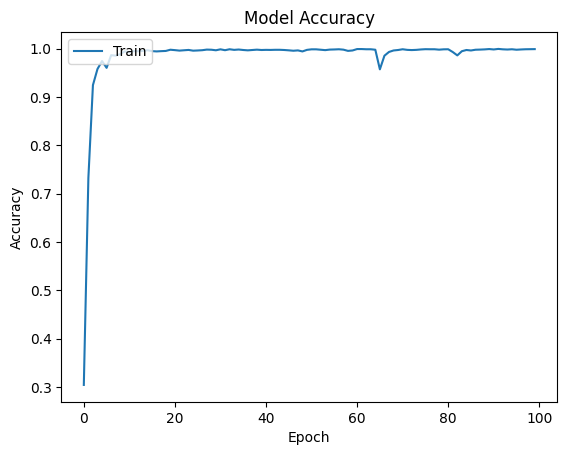

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train'], loc='upper left')
plt.show()

In [ ]:
Hybrid_model.save("hybrid_model.hdf5")

<h1>Testing<h1>


In [ ]:
# load best weights-3D CNN model
model_3D_CNN.load_weights("model_3D_CNN.hdf5")
model_3D_CNN.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
# load best weights-hybrid model
Hybrid_model.load_weights("hybrid_model.hdf5")
Hybrid_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(3075, 25, 25, 30, 1)

In [ ]:
ytest = to_categorical(ytest)
ytest.shape

(3075, 16)

<h1>Result of 3D CNN

In [ ]:
Y_pred_test_3D = model_3D_CNN.predict(Xtest)
y_pred_test_3D = np.argmax(Y_pred_test_3D, axis=1)

classification_3D= classification_report(np.argmax(ytest, axis=1), y_pred_test_3D,target_names=class_name)
print(classification_3D)

97/97 [==============================] - 1s 7ms/step
                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        14
                 Corn-notill       1.00      1.00      1.00       428
                Corn-mintill       1.00      1.00      1.00       249
                        Corn       1.00      1.00      1.00        71
               Grass-pasture       1.00      1.00      1.00       145
                 Grass-trees       1.00      1.00      1.00       219
         Grass-pasture-mowed       1.00      1.00      1.00         8
               Hay-windrowed       1.00      1.00      1.00       143
                        Oats       1.00      1.00      1.00         6
              Soybean-notill       1.00      1.00      1.00       292
             Soybean-mintill       1.00      1.00      1.00       737
               Soybean-clean       1.00      0.99      1.00       178
                       Wheat       1

<h1>Result of Hybrid CNN

In [ ]:
Y_pred_test_hybrid = Hybrid_model.predict(Xtest)
y_pred_test_hybrid = np.argmax(Y_pred_test_hybrid, axis=1)

classification_hybrid = classification_report(np.argmax(ytest, axis=1), y_pred_test_hybrid,target_names=class_name)
print(classification_hybrid)

97/97 [==============================] - 1s 10ms/step
                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        14
                 Corn-notill       1.00      1.00      1.00       428
                Corn-mintill       1.00      1.00      1.00       249
                        Corn       1.00      1.00      1.00        71
               Grass-pasture       1.00      1.00      1.00       145
                 Grass-trees       1.00      1.00      1.00       219
         Grass-pasture-mowed       1.00      1.00      1.00         8
               Hay-windrowed       1.00      1.00      1.00       143
                        Oats       1.00      1.00      1.00         6
              Soybean-notill       1.00      1.00      1.00       292
             Soybean-mintill       1.00      1.00      1.00       737
               Soybean-clean       1.00      0.99      1.00       178
                       Wheat       

In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]

    return patch

In [ ]:
# load the original image
X, y = loadData()

In [ ]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [ ]:
X,pca = applyPCA(X, numComponents=numComponents)

In [ ]:
X = padWithZeros(X, PATCH_SIZE//2)

<h1>Predicted Image by 3D CNN

In [ ]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
            prediction = (model_3D_CNN.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 27ms/step


/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning:

Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.



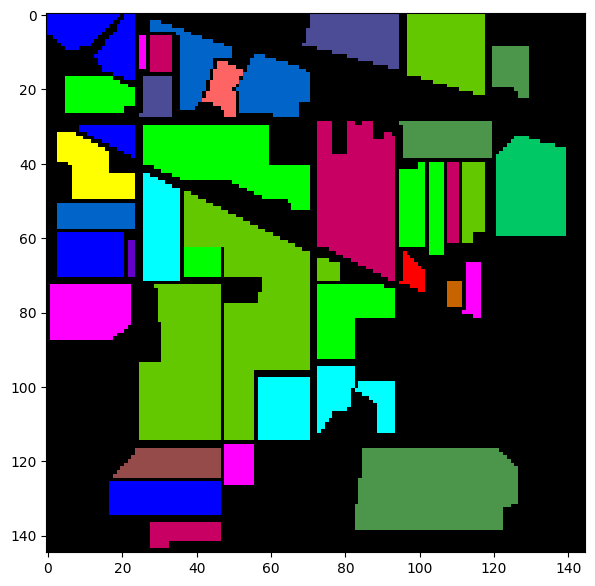

In [ ]:
ground_truth = spectral.imshow(classes=y, figsize=(7, 7))

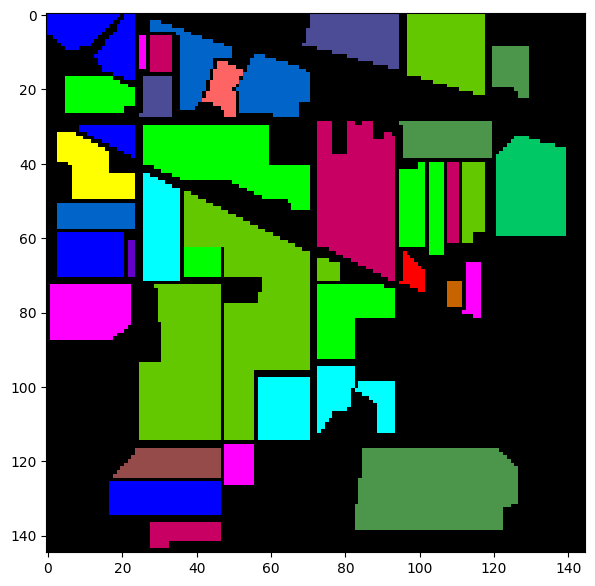

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

# Predicted Image by Hybrid CNN

In [ ]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
            prediction = (Hybrid_model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 34ms/step


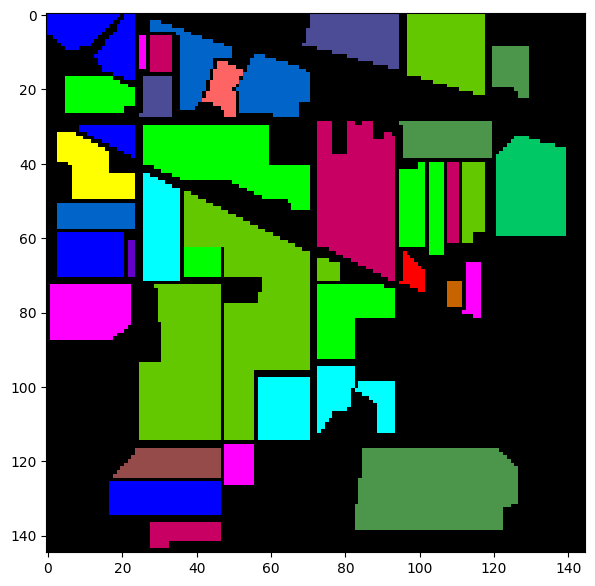

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

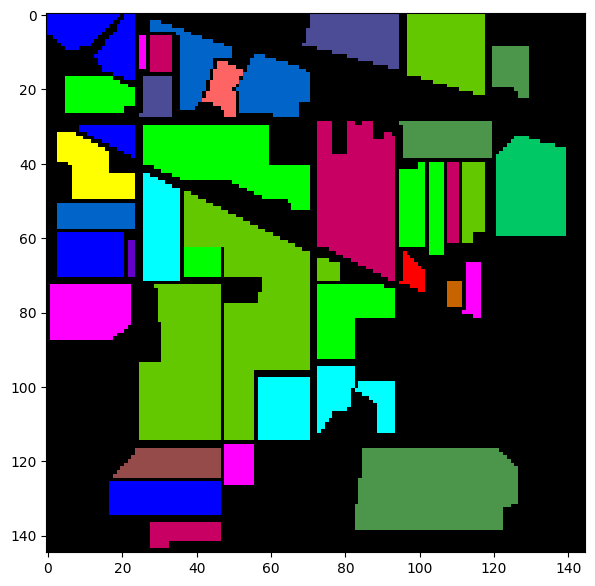

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))